In [1]:
import numpy as np
import os, sys
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from pathlib import Path
from numba import njit
import seaborn as sns

sys.path.append(os.path.abspath(os.path.join('../src')))
from varying_drift_diffusion import *
from motion_simulation import *
from accumulators import *

# bayesflow
sys.path.append(os.path.abspath(os.path.join('../../BayesFlow')))
from bayesflow.networks import InvariantNetwork, InvertibleNetwork
from bayesflow.amortizers import SingleModelAmortizer
from bayesflow.trainers import ParameterEstimationTrainer
from bayesflow.diagnostics import *

from tensorflow.keras.layers import Dense, GRU, LSTM, Conv1D, MultiHeadAttention, GlobalAveragePooling1D
from tensorflow.keras.models import Sequential
from tensorflow.python.keras.utils.np_utils import to_categorical

In [2]:
# gpu_devices = tf.config.experimental.list_physical_devices('GPU')
# for device in gpu_devices: tf.config.experimental.set_memory_growth(device, True)

In [3]:
%load_ext autoreload
%autoreload 2
np.set_printoptions(suppress=True)

## Constants

In [2]:
# simulation 
N_SIM = 500
N_OBS = 100

# bayesflow
PARAM_NAMES = ["a", "ndt", "bias", "kappa"]
N_PARAMS = len(PARAM_NAMES)
N_EPOCHS = 50
ITER_PER_EPOCH = 1000
BATCH_SIZE = 32
N_SAMPLES = 2000

## Simulator Test

In [3]:
n_obs = 100
a     = 3.0
ndt   = 0.2
bias  = 0.5
kappa = 5
theta = np.array([a, ndt, bias, kappa])

unique_motions = np.array([-0.725, -0.675, -0.625, -0.575, -0.525, 0.525,  0.575,  0.625,  0.675,  0.725], dtype=np.float32)
amplitude = np.repeat(unique_motions, 10)
motion_set, condition = motion_experiment_manual(1, amplitude, 1)

rt, resp = var_dm_simulator(theta, 1, motion_set)


In [4]:
%time
p_, x_ = var_dm_batch_simulator(32, 100)
x_.shape

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs


(32, 100, 12)

## Bayes Flow

In [6]:
class CustomSummary(tf.keras.Model):
    
    def __init__(self, meta_inv, n_out=10):
        super(CustomSummary, self).__init__()
        self.inv = InvariantNetwork(meta_inv)
        self.out = Dense(n_out)
        
    def call(self, x):
        return self.out(self.inv(x)) 

In [7]:
sum_meta = {
    'n_dense_s1': 2,
    'n_dense_s2': 2,
    'n_dense_s3': 2,
    'n_equiv':    2,
    'dense_s1_args': {'activation': 'relu', 'units': 32},
    'dense_s2_args': {'activation': 'relu', 'units': 32},
    'dense_s3_args': {'activation': 'relu', 'units': 32},
}

# invertable inference network
inf_meta = {
    'n_coupling_layers': 4,
    's_args': {
        'units': [128, 128],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    't_args': {
        'units': [128, 128],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    'alpha': 1.9,
    'permute': True,
    'use_act_norm': True,
    'n_params': N_PARAMS
}

inference_net = InvertibleNetwork(inf_meta)
summary_net = CustomSummary(sum_meta)
amortizer = SingleModelAmortizer(inference_net, summary_net)

2021-12-22 10:56:53.273678: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
# Learning-rate decay
learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
    0.0005, 1000, 0.99, staircase=True
)

trainer = ParameterEstimationTrainer(
    network=amortizer, 
    generative_model=var_dm_batch_simulator,
    learning_rate=learning_rate,
    checkpoint_path='../src/selected_checkpoints/time_var_dm2',
    clip_value=3,
    max_to_keep=5
)

Networks loaded from ../src/selected_checkpoints/time_var_dm2/ckpt-55


In [9]:
# Learning-rate decay
# trainer.optimizer = tf.keras.optimizers.Adam(0.00007)

In [10]:
# # %%time
# # # online training
# losses = trainer.train_online(5, ITER_PER_EPOCH, BATCH_SIZE, n_obs=N_OBS)

## Parameter Recovery

In [11]:
# Simulate and amortized inference
p_, x_ = var_dm_batch_simulator(n_sim=N_SIM,n_obs=N_OBS)

In [12]:
samples = amortizer.sample(x_, n_samples=N_SAMPLES)
param_means = samples.mean(axis=1)

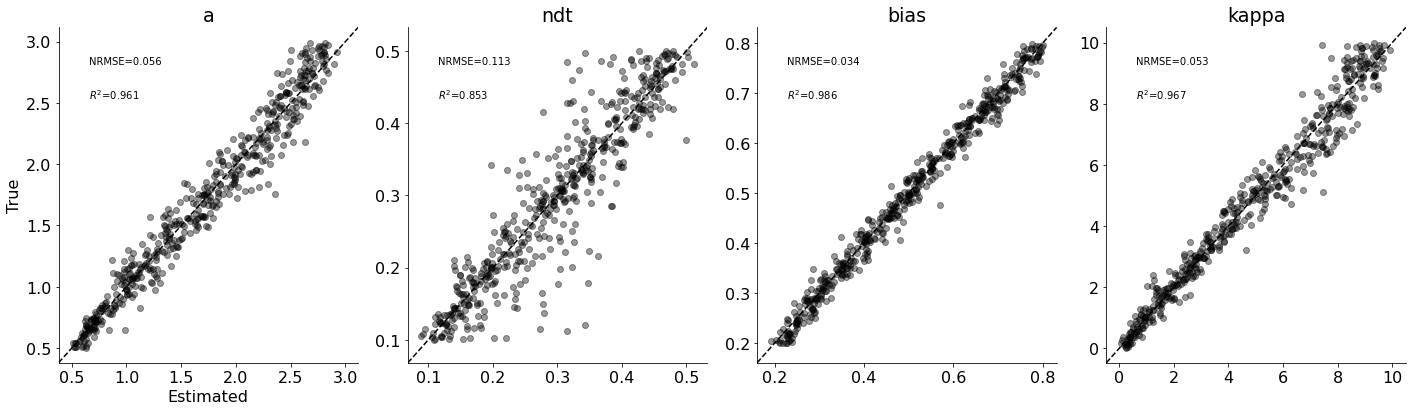

In [13]:
# Recovery plot
f = true_vs_estimated(theta_true=p_, theta_est=param_means,
                  param_names=PARAM_NAMES, dpi=300, figsize=(20,6),font_size=16)

## Simulation Based Calibration

In [15]:
# Simulate
n_sbc = 5000
n_post_samples_sbc = 250
params, sim_data = var_dm_batch_simulator(n_sbc, N_OBS)

In [16]:
# Amortized inference
param_samples = np.concatenate([amortizer.sample(x, n_post_samples_sbc)
                                for x in tf.split(sim_data, 10, axis=0)], axis=0)

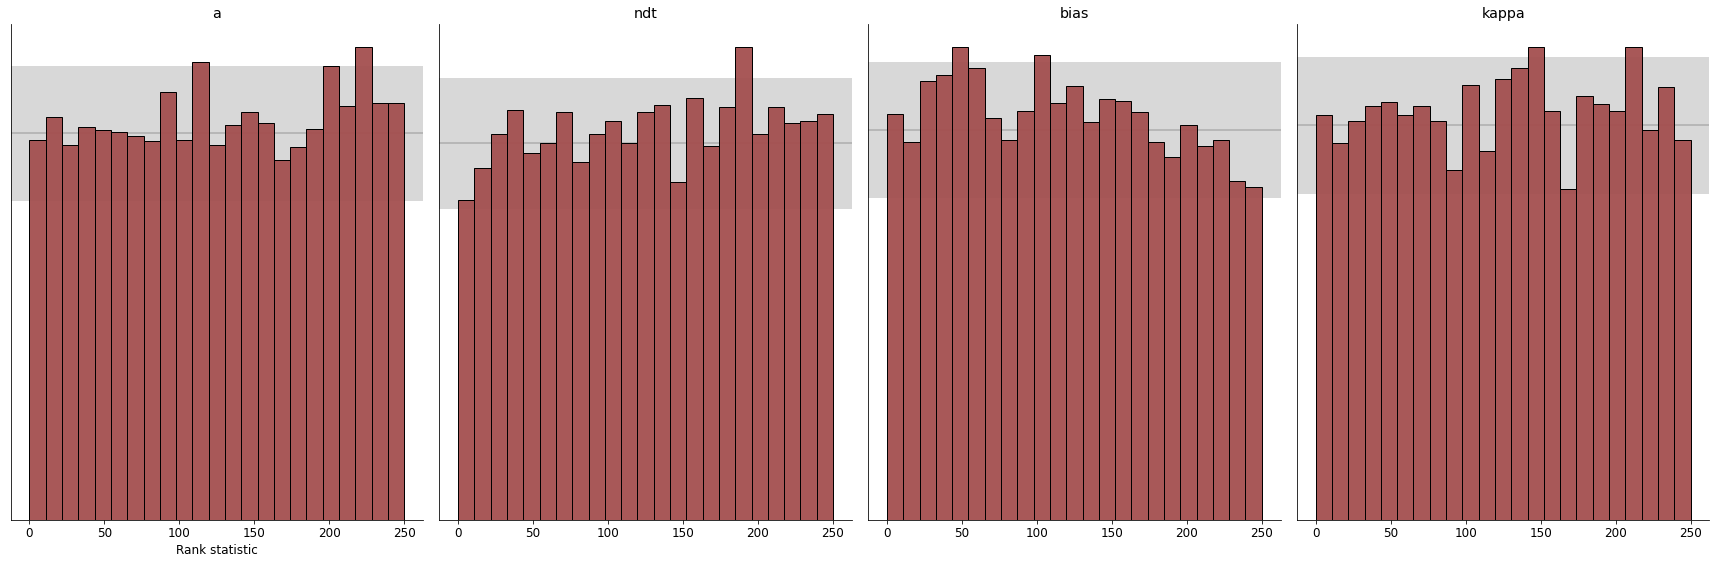

In [17]:
# Rank-plot
f = plot_sbc(param_samples, params, param_names=PARAM_NAMES, figsize=(24, 8), bins=23)

## Bayesian Eye Chart

In [18]:
# Simulation
true_params, sim_data = var_dm_batch_simulator(N_SIM, N_OBS)

# Amortized inference
param_samples = np.concatenate([amortizer.sample(x, N_SAMPLES)
                                for x in tf.split(sim_data, 10, axis=0)], axis=0)

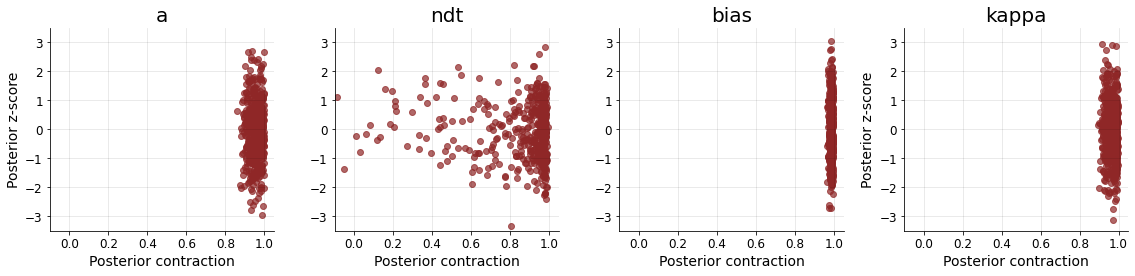

In [19]:
### Posterior z-score
# Compute posterior means and stds
post_means = param_samples.mean(1)
post_stds = param_samples.std(1)
post_vars = param_samples.var(1)

# Compute posterior z score
post_z_score = (post_means - true_params) / post_stds

### Posterior contraction, i.e., 1 - post_var / prior_var
prior_a = (0.5, 0.1, 0.2, 0.0) # lower bound of uniform prior
prior_b = (3.0, 0.5, 0.8, 10.0) # upper bound of uniform prior

# Compute prior vars analytically
prior_vars = np.array([(b-a)**2/12 for a,b in zip(prior_a, prior_b)])
# prior_vars = np.concatenate((prior_vars[0:2], np.array([0.0025]), prior_vars[2:]))
post_cont = 1 - post_vars / prior_vars

# Plotting time
f, axarr = plt.subplots(1, 4, figsize=(16, 4))
for i, (p, ax) in enumerate(zip(PARAM_NAMES, axarr.flat)):


    ax.scatter(post_cont[:, i], post_z_score[:, i], color='#8f2727', alpha=0.7)
    ax.set_title(p, fontsize=20)
    sns.despine(ax=ax)
    ax.set_xlim([-0.1, 1.05])
    ax.set_ylim([-3.5, 3.5])
    ax.grid(color='black', alpha=0.1)
    ax.set_xlabel('Posterior contraction', fontsize=14)
    if i == 0 or i == 3:
        ax.set_ylabel('Posterior z-score', fontsize=14)
f.tight_layout()

## Posterior Retrodictive Checks

### Empirical Data Preparation

In [18]:
# read data
directory = str(Path().absolute())
path = str(Path(directory).parents[0]) + '/data/single_sub_data.csv'
data = np.loadtxt(open(path, 'rb'), delimiter=",", skiprows=1)

# subset data
data_subset = data[(data[:, 1] == 1) & (data[:, 2] == 1)]

In [19]:
# get one hot encoded amplitude
amplitude = data_subset[:, 4]
condition = get_hot_encoded_amplitude(amplitude)

# prepare data for amortized inference
final_data = np.hstack((np.expand_dims(data_subset[:, 6], axis=1),
                        np.expand_dims(data_subset[:, 5], axis=1), condition))

final_data = np.expand_dims(final_data, axis=0)

final_data.shape

(1, 100, 12)

### Amortized Inference

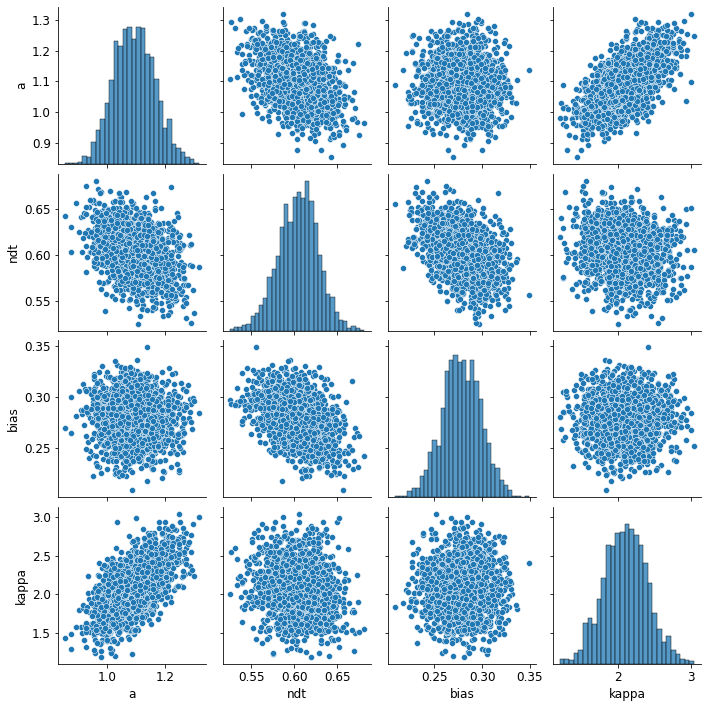

In [20]:
samples = amortizer.sample(final_data, n_samples=N_SAMPLES)
sns.pairplot(pd.DataFrame(samples, columns=PARAM_NAMES))

### Plotting

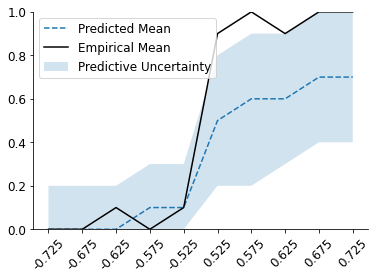

In [21]:
emp_data = data_subset[:, -3:]
pred_data = var_dm_pp_check(emp_data, samples)

In [22]:
tmp = pred_data[0, :]
quantiles = [0.1, 0.3, 0.5, 0.7, 0.9]
np.quantile(tmp[:, 0], quantiles)

array([0.87602979, 1.16482983, 1.56202984, 2.48672979, 3.99752972])

In [23]:
unique_amplitude  = np.round(np.sort(np.unique(amplitude)), 3)
n_sim             = samples.shape[0]
rt_quantiles      = [0.1, 0.3, 0.5, 0.7, 0.9]
pred_rt_quantiles = np.empty((n_sim, 10, len(rt_quantiles)))

for sim in range(n_sim):
        # iterate over amplitudes
        for i in range(len(unique_amplitude)):
            tmp_data = pred_data[sim, (pred_data[sim, :, 2] == unique_amplitude[i]), :]
            pred_rt_quantiles[sim, i] = np.quantile(tmp_data[:, 0], rt_quantiles)

In [26]:
pred_rt_quantiles = np.quantile(pred_rt_quantiles, [0.025, 0.5, 0.975], axis=0)
pred_rt_quantiles.shape

(3, 10, 5)

In [41]:
emp_rt_quantiles = np.empty((10, len(rt_quantiles)))
for i in range(len(unique_amplitude)):
    tmp_data = emp_data[(np.round(emp_data[:, 0], 3) == unique_amplitude[i]), 2]
    emp_rt_quantiles[i] = np.quantile(tmp_data, rt_quantiles)


In [42]:
emp_rt_quantiles.shape

(10, 5)

([<matplotlib.axis.XTick at 0x7ff19aba3040>,
 [Text(0, 0, '-0.725'),
  Text(1, 0, '-0.675'),
  Text(2, 0, '-0.625'),
  Text(3, 0, '-0.575'),
  Text(4, 0, '-0.525'),
  Text(5, 0, '0.525'),
  Text(6, 0, '0.575'),
  Text(7, 0, '0.625'),
  Text(8, 0, '0.675'),
  Text(9, 0, '0.725')])

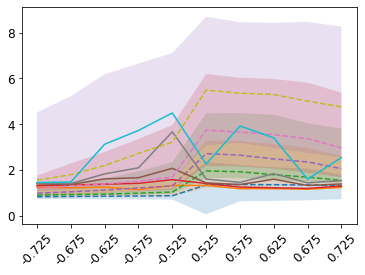

In [45]:
for i in range(len(rt_quantiles)):
    plt.plot(range(len(unique_amplitude)), pred_rt_quantiles[1, :, i], label="Predicted Mean", linestyle='dashed')
    plt.fill_between(range(len(unique_amplitude)), pred_rt_quantiles[0, :, i], pred_rt_quantiles[2, :, i],
                     alpha=0.2, label="Predictive Uncertainty")
    plt.plot(range(len(unique_amplitude)), emp_rt_quantiles[:, i], label="Empirical Quantiles",
             linestyle="solid")
plt.xticks(range(len(unique_amplitude)), unique_amplitude, rotation=45)
